# Introduction

Google has spent over 1.1 Billion dollars on self driving cars. Uber has 1.5 Billion dollars allocated to self driving cars. Tesla has already built a sort of car autopilot into their vehicles. Self driving cars are on there way, but how do you build one?

There are two components to a self driving vehicle: the hardware (which we will ignore) and the software. Part of that software is noting other bodies moving through space, and part of that software is knowing and following the rules of the road.

My final capstone looks at how to quickly read road signs so as to be able to make snap driving decisions in high intesnsity situations. I am primarily focused on a type of machine learning model known as Convolutional Neural Networks. This project focuses on altering kernels and density layer neurons to increase accuracy while not sacrificing computational time.

The metrics I will be watching most closely are test loss and test accuracy. The lower the test loss, the more accurate our model. The closer to one our test accuracy is , the more accurate the model is. 

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
#import matplotlib.pyplot as plt
from math import sqrt, ceil
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import keras.metrics
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import Image
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import time
import os

In [4]:

for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#print(os.listdir('../input'))
# Any results we write to the current directory are saved as output

In [5]:
# Opening file for reading in binary mode
with open('data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
y_train = to_categorical(data['y_train'], num_classes=43)
y_validation = to_categorical(data['y_validation'], num_classes=43)
y_test = data['y_test']

# Making channels come at the end
x_train = data['x_train'].transpose(0, 2, 3, 1)
x_validation = data['x_validation'].transpose(0, 2, 3, 1)
x_test = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43

x_validation: (4410, 3, 32, 32)
y_test: (12630,)
y_validation: (4410,)
x_train: (86989, 3, 32, 32)
x_test: (12630, 3, 32, 32)
labels: 43
y_train: (86989,)


Here is a look at what some of those signs might be

(81, 32, 32, 3)


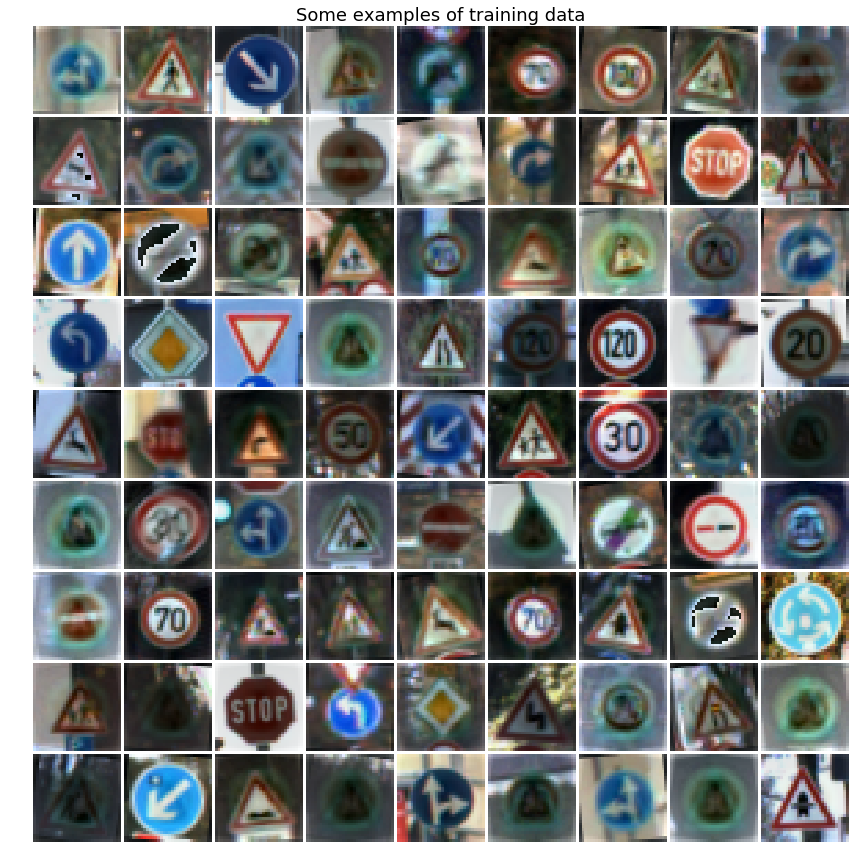

In [8]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = x_train[:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

# Modeling Experimentation

This is a model with only one kernel. The kernel is a matrix of weights that is multiplied with each part of our input. All the results from these multiplications put together form our activation map. Each graph below represents what the weights look like to some extent with each different kernel size.

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=1, padding='same', activation='relu',
                input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
             metrics=['accuracy'])


Here we are fitting the model. I timed how long each model fitting took to see if models that took longer to fit were better at performance. 

In [17]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 102.20042848587036 seconds ---


The accuracy of this model isn't terrible. This will be our baseline for model performance going forward.

In [18]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.4202143292848757
Test accuracy: 0.6730158730158731


(1, 1, 3, 32)
(32, 1, 1, 3)


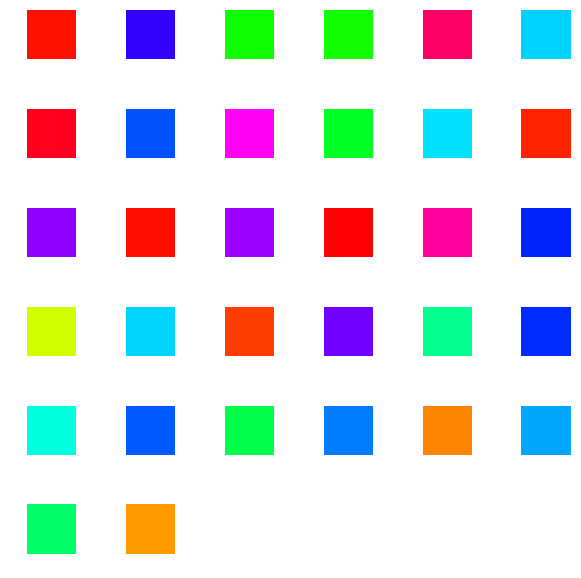

In [20]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 2 (Kernel at 2)

In [25]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 107.99208092689514 seconds ---


In [27]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.689000676102649
Test accuracy: 0.8467120181676212


(2, 2, 3, 32)
(32, 2, 2, 3)


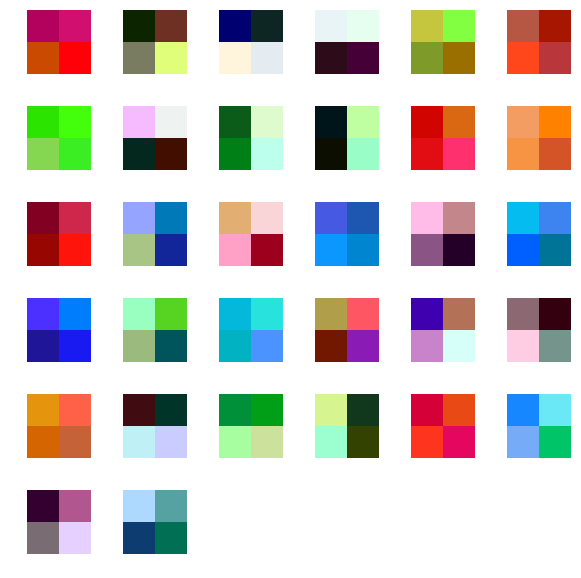

In [28]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 3 (Kernel at 3)

In [29]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 118.07528042793274 seconds ---


In [31]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6941176410705324
Test accuracy: 0.8496598639726098


(3, 3, 3, 32)
(32, 3, 3, 3)


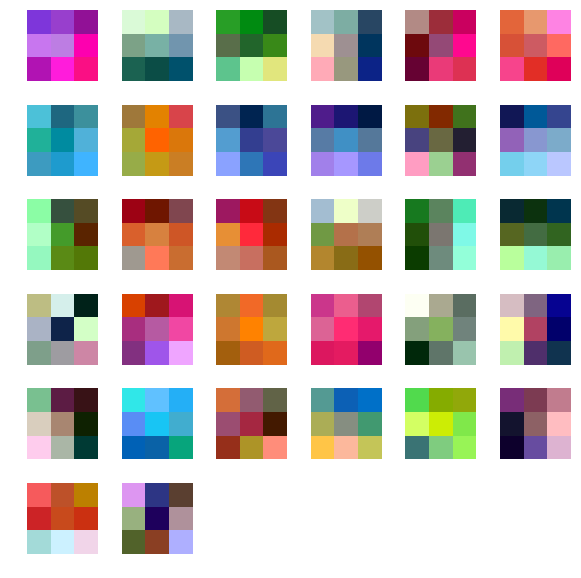

In [32]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 4 (Kernel at 4)

In [33]:
model = Sequential()
model.add(Conv2D(32, kernel_size=4, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 128.16905641555786 seconds ---


In [35]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9065441038062513
Test accuracy: 0.8204081631571798


(4, 4, 3, 32)
(32, 4, 4, 3)


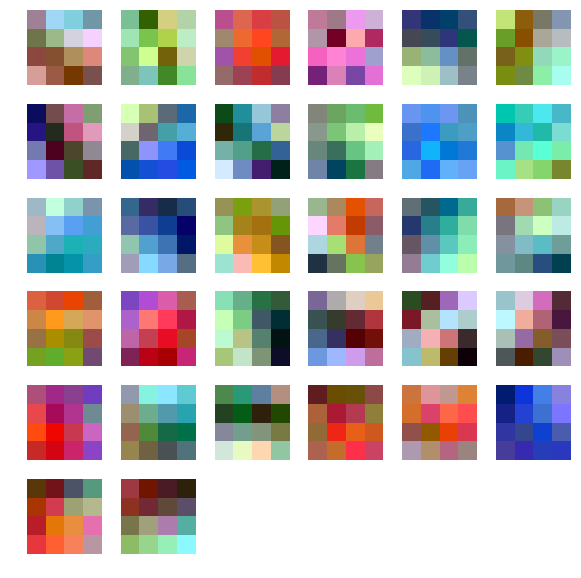

In [36]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 5 (Kernel at 5)

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=5, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 145.56558513641357 seconds ---


In [39]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0918637566555656
Test accuracy: 0.8253968253157307


(5, 5, 3, 32)
(32, 5, 5, 3)


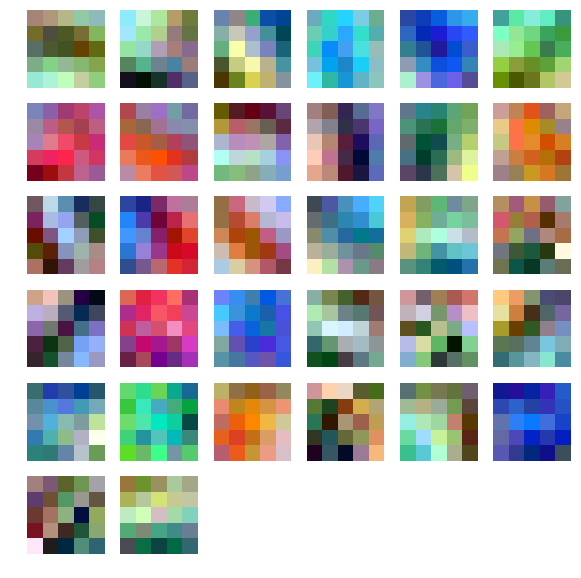

In [40]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 6 (Kernel at 6)

In [41]:
model = Sequential()
model.add(Conv2D(32, kernel_size=6, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 163.57180857658386 seconds ---


In [43]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8275337818798835
Test accuracy: 0.853968253833096


(6, 6, 3, 32)
(32, 6, 6, 3)


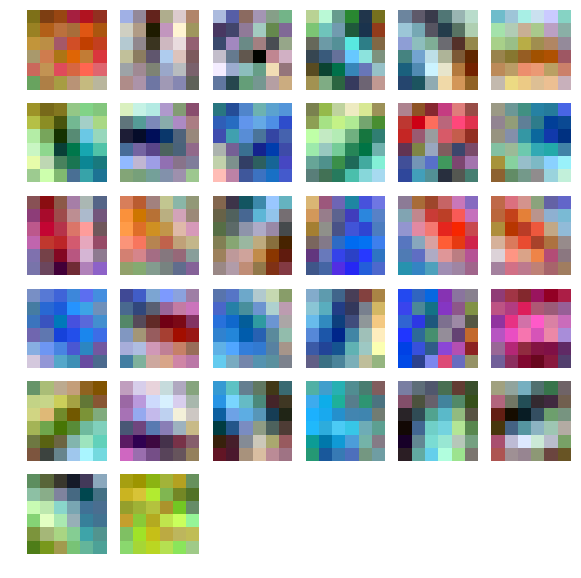

In [44]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 7 (Kernel at 7)

In [45]:
model = Sequential()
model.add(Conv2D(32, kernel_size=7, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 177.98179459571838 seconds ---


In [47]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9752437439635228
Test accuracy: 0.834013605307019


(7, 7, 3, 32)
(32, 7, 7, 3)


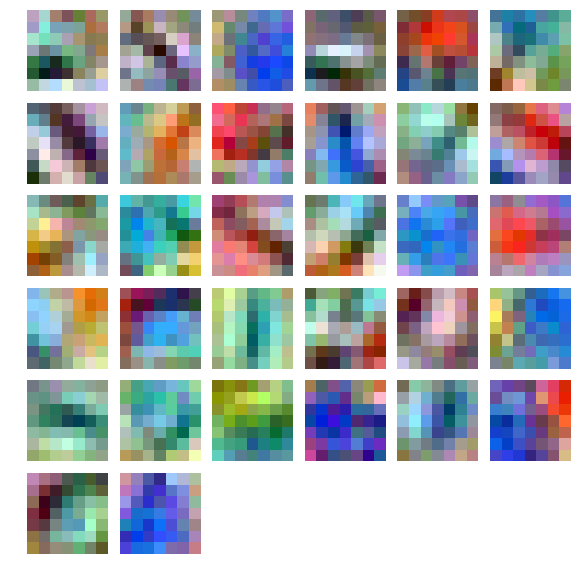

In [48]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 8 (Kernel at 8)

In [49]:
model = Sequential()
model.add(Conv2D(32, kernel_size=8, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 184.5063123703003 seconds ---


In [51]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9827890204193911
Test accuracy: 0.8358276644261246


(8, 8, 3, 32)
(32, 8, 8, 3)


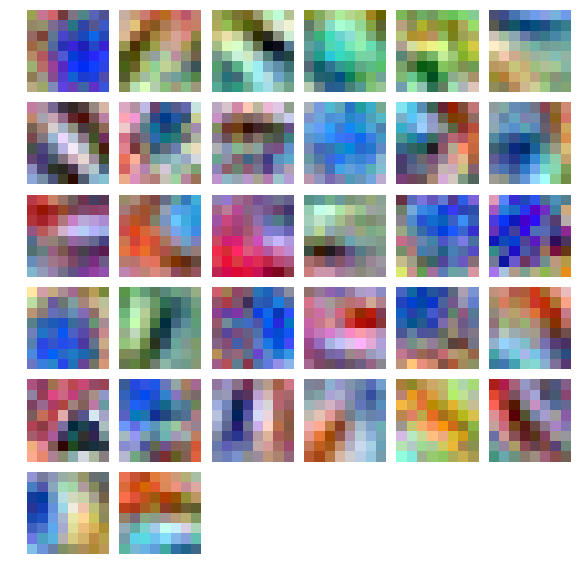

In [52]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 9 (Kernel at 9)

In [53]:
model = Sequential()
model.add(Conv2D(32, kernel_size=9, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 216.8506474494934 seconds ---


In [55]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1590758565872434
Test accuracy: 0.8115646259044033


(9, 9, 3, 32)
(32, 9, 9, 3)


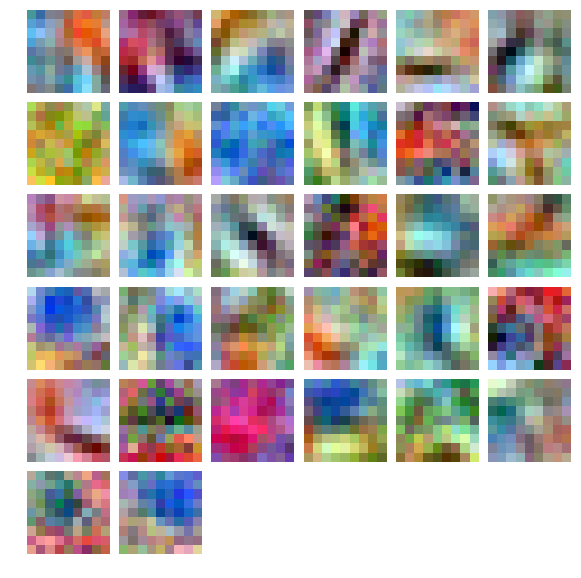

In [56]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Making model # 10 (Kernel at 10)

In [57]:
model = Sequential()
model.add(Conv2D(32, kernel_size=10, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 238.4643359184265 seconds ---


In [59]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1296773658588088
Test accuracy: 0.811791383328081


(10, 10, 3, 32)
(32, 10, 10, 3)


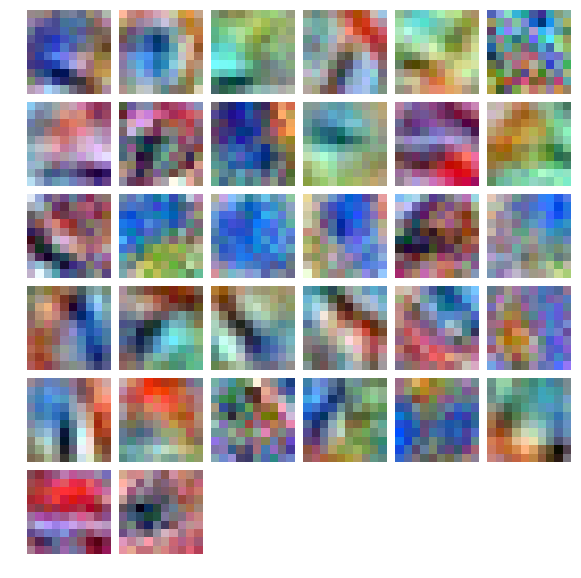

In [60]:
w = model.get_weights()
print(w[0].shape)
temp = w[0].transpose(3, 0, 1, 2)
print(temp.shape)  # (81, 32, 32, 3)
fig = plt.figure()
grid = convert_to_grid(temp)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()
plt.close()

# Reflection on Kernels

It seems that for this project, performance begins to stall around 2 kernels. I will keep this as my baseline for my next model tweak: adding an additonal density layer to my model.

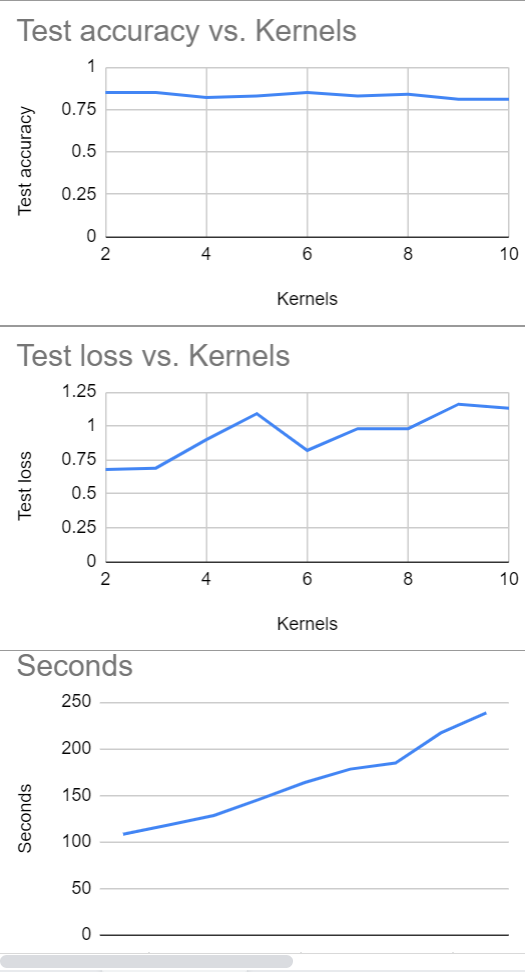

In [70]:
Image("Capture.png")

# Density Layers

Density layers feed all outputs from the previous layer through all its neurons, each neuron providing one output to the next layer. Here we are experimenting with the number of neurons in the a new density layer.  

# Making model # 11 (Density Layer at 1) 

In [61]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 57.72654414176941 seconds ---


In [63]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 3.7562839880011247
Test accuracy: 0.013605442176870748


# Making model # 12 (Density Layer at 10) 

In [64]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 64.3867347240448 seconds ---


In [66]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0613079617623569
Test accuracy: 0.668027210803259


# Making model # 13 (Density Layer at 50) 

In [67]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 122.47640800476074 seconds ---


In [71]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.829659496007863
Test accuracy: 0.7768707481911934


# Making model # 14 (Density Layer at 100) 

In [73]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 218.55456018447876 seconds ---


In [75]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6007305597772403
Test accuracy: 0.8365079365619997


# Making model # 15 (Density Layer at 150) 

In [77]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 305.3828456401825 seconds ---


In [79]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.777620839342779
Test accuracy: 0.8235827664939724


# Making model # 16 (Density Layer at 200) 

In [80]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 396.24030232429504 seconds ---


In [83]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7723773914129556
Test accuracy: 0.8206349206889838


# Reflections on Density Layers

It looks like in this circumstance, this new density layer either harmed or did not add anything to decreasing the test loss, and increasing the test accuracy.

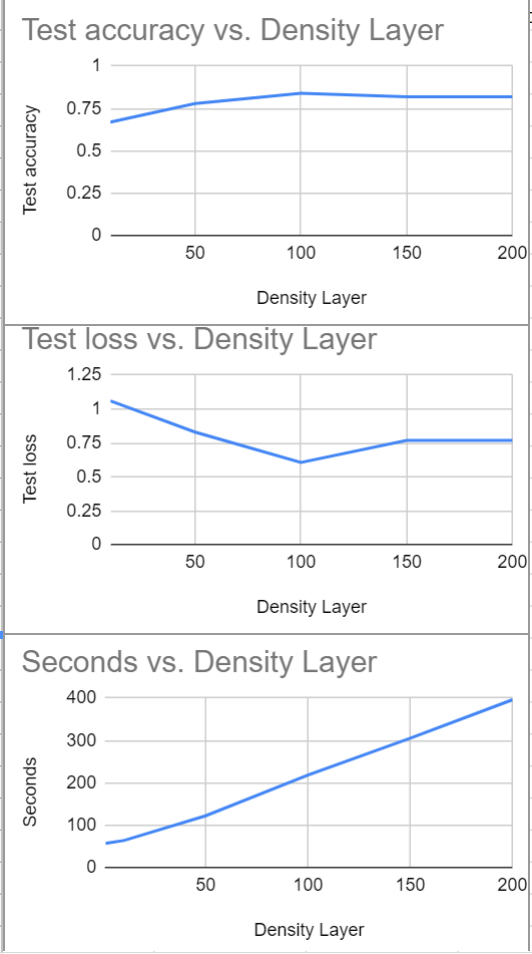

In [84]:
Image("Capture2.png")

In [85]:
model = Sequential()
model.add(Conv2D(32, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
start_time = time.time()
model.fit(x_train, y_train, batch_size=5, epochs = 1, validation_data =
         (x_validation, y_validation), verbose=0)
print("--- %s seconds ---" % (time.time() - start_time))

--- 116.44548463821411 seconds ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 32, 32, 3)
[3]
(43,)
ClassId: 3
Label: Speed limit (60km/h)
--- 0.020969867706298828 seconds ---


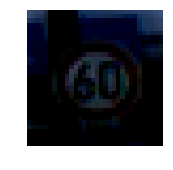

In [88]:
%matplotlib inline
start_time = time.time()

# Preparing image for predicting from test dataset
x_input = x_test[100:101]
print(x_input.shape)
y_input = y_test[100:101]
print(y_input)

plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
plt.imshow(x_input[0, :, :, :])
plt.axis('off')

# Showing the plot
#plt.show()

# Getting scores from forward pass of input image
scores = model.predict(x_input)
print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
prediction = np.argmax(scores)
print('ClassId:', prediction)

# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list


# Getting labels
labels = label_text('label_names.csv')

# Printing label for classified Traffic Sign
print('Label:', labels[prediction])

print("--- %s seconds ---" % (time.time() - start_time))
    

# Conclusion

Our model predicted the sign correctly, and in a fraction of a second. While I would not use this model in an actual car, it is still an impressive categorization model